In [115]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
display(HTML("<style>.prompt { display:none !important; }</style>"))

/var/folders/x4/rrtsylz93hz12pjyx32q8r580000gn/T/ipykernel_31468/1220833856.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


# Advanced Encryption System

Advanced Encryption Standard (AES) to symetryczny szyfr blokowy, następca szyfru DES. Został opublikowany po raz pierwszy w 1998 roku, a w 2001 został przyjęty jako standard.

AES jest oparty na algorytmie Rijndaela, którego autorami są belgijscy kryptografowie, Joan Daemen i Vincent Rijmen. 
Zaprezentowali oni swoją propozycję szyfru Instytucji NIST w ramach ogłoszonego konkursu.
NIST wybrał trzy algorytmy z rodziny Rijndaela, z których każdy miał tę samą wielkość bloku (128 bitów), ale miały różne długości klucza: 128, 192 i 256 bitów.

AES jest szyfrem opartym o sieć podstawieniowo-permutacyjną. Nie wykorzystuje sieci Feistela, a więc wszystkie operacje w algorytmie muszą mieć swoje wersje odwrotne. 

AES jest pierwszym (i jedynym) dostępnym publicznie szyfrem, który był zatwierdzony i wykorzystywany przez NSA do ochrony ściśle tajnych informacji.
W tym tutorialu zostanie przedstawiony wariant AES z kluczem o długości 128 bitów.

In [116]:
# funkcje pomocnicze 
def binary_to_decimal(binary_bits):
    """ Convert binary bits to decimal """
    decimal = int(binary_bits, 2)
    return decimal

def decimal_to_binary(decimal):
    """ Convert decimal to binary bits """
    binary4bits = bin(decimal)[2:].zfill(8)
    return binary4bits

def bytes_to_matrix(text):
    """ Converts a 16-byte array into a 4x4 matrix. """
    bytes_table = [text[i:i+8] for i in range(0, len(text), 8)]
    return [bytes_table[i:i+4] for i in range(0, 16, 4)]

def hex_to_binary(hex_code):
    """ Converts hex number into binary string such that (len(bin_string) % 8 == 0) """
    bin_code = bin( hex_code )[2:]
    padding = (8 - len(bin_code)%8)%8
    return '0' * padding + bin_code

#diagnostyka:
# print(decimal_to_binary(15))
# print(binary_to_decimal("00001111"))
# print(decimal_to_binary(0))
# print(hex_to_binary(0x100))

## **Operacje w ciele skończonym Galois**

W ciele skończonym Galois są zdefiniowane operacje dodawania, odejmowania, mnożenia i dzielenia (z wyjątkiem dzielenia przez 0), które zwracają ośmiobitowe wyniki.
AES używa mnożenia (gmul) i operacji odwrotnej w kroku mixColumns.

#### Gmul Mnożenie

Schemat:
1. Weź dwie ośmiobitowe liczby a, b i iloczyn p
2. p = 0
3. Pętla (8 razy)
    * Jeżeli najmniej znaczący bit (low bit) == 1 to p = p ^ a
    * Przesuń a o jeden bit w lewo, usuwając najbardziej znaczący bit (high bit) i ustawiając najmniej znaczący bit na 0 
    * Jeśli przed przesunięciem bitowym (w poprzednim kroku) najbardziej znaczący bit a był ustawiony na 1 to a = a ^ 0x1b
    * Przesuń b o jeden bit w prawo, usuwając najmniej znaczący bit i ustawiając najbardziej znaczący bit na 0.
4. Zwróć p 

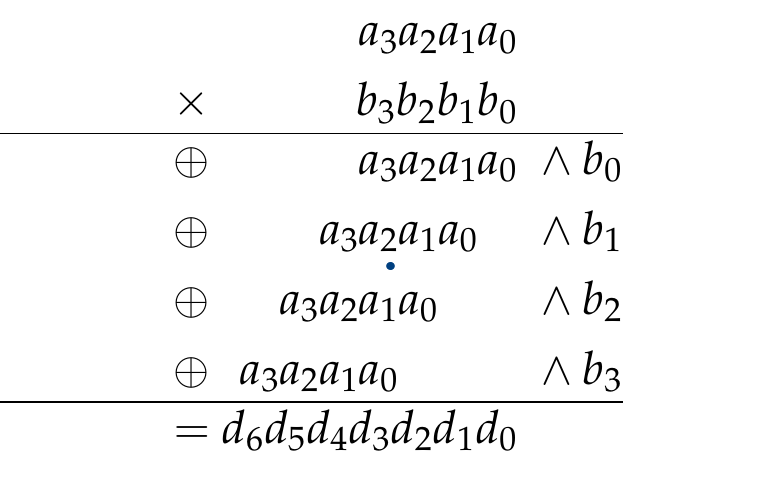

In [117]:
# funkcje pomocnicze dla operacji w ciele Galois
def gadd(a, b):
    return a ^ b

def gsub(a, b):
    return a ^ b

def gmul(a, b):
    p = 0
    for i in range(8):
        if b & 1 == 1:
            p = p ^ a
        prev_a = a
        a = (a << 1) % 256
        
        hi_bit_set = prev_a & 0x80   #0x80 --> 10000000
        if hi_bit_set == 0x80:
            a = a ^ 0x1b
        b = b >> 1 
    return p

gmul(7, 3)

9

### S-Box
Podobnie jak DES, AES używa mechanizmu sboxów (s-box). 
Sboxy mają za zadanie wprowadzenie nieliniowości do przekształcenia bloku bitów (sprawienie, aby korelacja między tekstem jawnym, a szyfrogramem była jak najmniejsza). Design S-boxów AES uwzględnia warunek uzyskania efektu lawinowego (strict avalanche effect) to znaczy zmiana 1 bitu wejściowego powinna wywołać zmianę wszystkich bitów wyjściowych z 50% prawdopodobieństwem. Poniżej przedstawiono zawartość SBOX oraz INVERSE_SBOX dla AES. W celu wygenerowania SBOX (oraz wersji odwrotnej) wykonywana jest operacja obliczania elementu odwrotnego w ciele skończonym Galois.

In [118]:
SBOX = [
    0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
    0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
    0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
    0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
    0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
    0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
    0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
    0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
    0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
    0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
    0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
    0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
    0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
    0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
    0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
    0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16,
]

INV_SBOX = [
    0x52, 0x09, 0x6A, 0xD5, 0x30, 0x36, 0xA5, 0x38, 0xBF, 0x40, 0xA3, 0x9E, 0x81, 0xF3, 0xD7, 0xFB,
    0x7C, 0xE3, 0x39, 0x82, 0x9B, 0x2F, 0xFF, 0x87, 0x34, 0x8E, 0x43, 0x44, 0xC4, 0xDE, 0xE9, 0xCB,
    0x54, 0x7B, 0x94, 0x32, 0xA6, 0xC2, 0x23, 0x3D, 0xEE, 0x4C, 0x95, 0x0B, 0x42, 0xFA, 0xC3, 0x4E,
    0x08, 0x2E, 0xA1, 0x66, 0x28, 0xD9, 0x24, 0xB2, 0x76, 0x5B, 0xA2, 0x49, 0x6D, 0x8B, 0xD1, 0x25,
    0x72, 0xF8, 0xF6, 0x64, 0x86, 0x68, 0x98, 0x16, 0xD4, 0xA4, 0x5C, 0xCC, 0x5D, 0x65, 0xB6, 0x92,
    0x6C, 0x70, 0x48, 0x50, 0xFD, 0xED, 0xB9, 0xDA, 0x5E, 0x15, 0x46, 0x57, 0xA7, 0x8D, 0x9D, 0x84,
    0x90, 0xD8, 0xAB, 0x00, 0x8C, 0xBC, 0xD3, 0x0A, 0xF7, 0xE4, 0x58, 0x05, 0xB8, 0xB3, 0x45, 0x06,
    0xD0, 0x2C, 0x1E, 0x8F, 0xCA, 0x3F, 0x0F, 0x02, 0xC1, 0xAF, 0xBD, 0x03, 0x01, 0x13, 0x8A, 0x6B,
    0x3A, 0x91, 0x11, 0x41, 0x4F, 0x67, 0xDC, 0xEA, 0x97, 0xF2, 0xCF, 0xCE, 0xF0, 0xB4, 0xE6, 0x73,
    0x96, 0xAC, 0x74, 0x22, 0xE7, 0xAD, 0x35, 0x85, 0xE2, 0xF9, 0x37, 0xE8, 0x1C, 0x75, 0xDF, 0x6E,
    0x47, 0xF1, 0x1A, 0x71, 0x1D, 0x29, 0xC5, 0x89, 0x6F, 0xB7, 0x62, 0x0E, 0xAA, 0x18, 0xBE, 0x1B,
    0xFC, 0x56, 0x3E, 0x4B, 0xC6, 0xD2, 0x79, 0x20, 0x9A, 0xDB, 0xC0, 0xFE, 0x78, 0xCD, 0x5A, 0xF4,
    0x1F, 0xDD, 0xA8, 0x33, 0x88, 0x07, 0xC7, 0x31, 0xB1, 0x12, 0x10, 0x59, 0x27, 0x80, 0xEC, 0x5F,
    0x60, 0x51, 0x7F, 0xA9, 0x19, 0xB5, 0x4A, 0x0D, 0x2D, 0xE5, 0x7A, 0x9F, 0x93, 0xC9, 0x9C, 0xEF,
    0xA0, 0xE0, 0x3B, 0x4D, 0xAE, 0x2A, 0xF5, 0xB0, 0xC8, 0xEB, 0xBB, 0x3C, 0x83, 0x53, 0x99, 0x61,
    0x17, 0x2B, 0x04, 0x7E, 0xBA, 0x77, 0xD6, 0x26, 0xE1, 0x69, 0x14, 0x63, 0x55, 0x21, 0x0C, 0x7D,
]

# Rozszerzanie klucza (*key scheduling*)
Pierwszym krokiem w implementacji AES o rozmiarze klucza 128 bitów jest wygenerowanie 11 128-bitowych podkluczy (key schedule). Key schedule służy do uzyskania kluczy rund.

1. Klucz główny K formuje tablicę zawierającą 4 bajtowe kolumny 
2. Operując na kolumnach generujemy kolejne podklucze rund:

    a) każda pierwsza kolumna podklucza generowana jest na podstawie kolumny wcześniejszej $i-4$: RotWord, SubBytes, AddRcon 
    
    b) kolejne kolumny generowane są na podstawie dwóch odpowiednich wcześniejszych kolumn $i-4$ oraz $i-1$ 
    

### Stałe rundy Rcon 

Dodanie stałej rundy Rcon(i) ma na celu między innymi eliminację potencjalnych słabych kluczy. Tablica stałych Rcon ma postać $[rc_i, 0x00, 0x00, 0x00 ]$ gdzie $rc_i$ jest odpowiednim wielomianem z ciała $GF(2^8)$. 

In [119]:
#Rc - stała rundy (round constant)
def rcon(i):
    c = 1
    if i == 1:
        return 1
    while i != 1:
        b = c * 2
    
        if c >= 0x80:
            b = b ^ 0x1B
            b = b % 256
        c = b
        i = i-1
    return b

val = rcon(10)    
print("Dec:", val, "hex:", hex(val))  

Dec: 54 hex: 0x36


## Zarządzanie kluczem w całości 


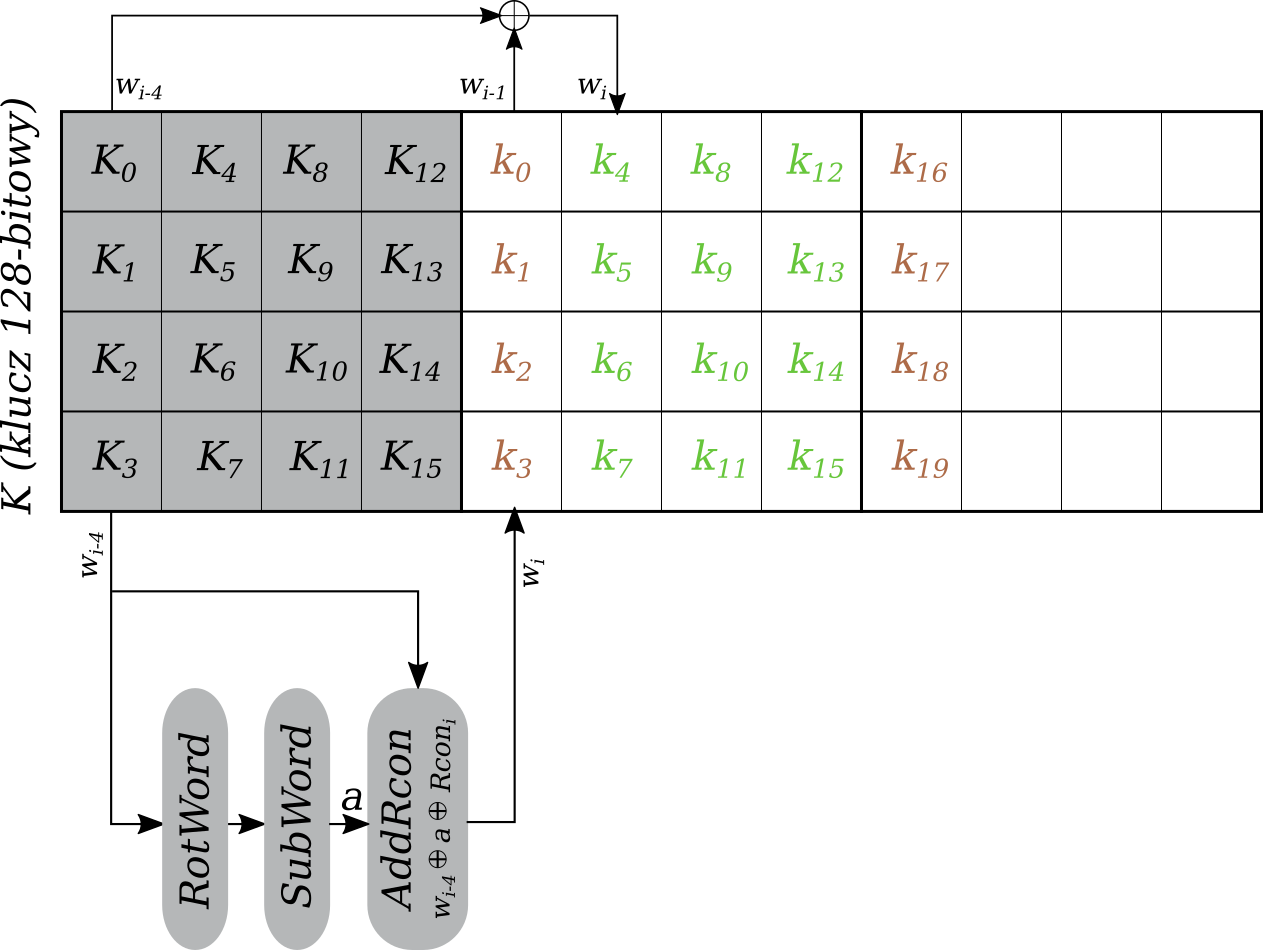

In [120]:
def rotate_32bits_word(word):
    return word[8:32] + word[0:8]


def schedule_core(v, i):
    #rotacja 
    v = rotate_32bits_word(v)
    out = ""
    #użyj s-boxa
    for n in range(4):
        n_byte = v[n*8:n*8+8]
        out = out + decimal_to_binary(SBOX[binary_to_decimal(n_byte)])
    
    first_byte = out[0:8]
    #dodaj rcon(i)
    xor = binary_to_decimal(first_byte) ^ rcon(i)
    out = decimal_to_binary(xor) + out[8:32]
    return out

print(rotate_32bits_word("00000000111111110111111101010101"))
print(schedule_core("00000000111111110111111101010101", 2))
print(schedule_core("00000000111111110111111101010101", 11))

11111111011111110101010100000000
00010100110100101111110001100011
01111010110100101111110001100011


In [121]:
def XOR(bits1,bits2):
    xor_result = ""
    for index in range(len(bits1)):
        if bits1[index] == bits2[index]: 
            xor_result += '0'
        else:
            xor_result += '1'
    return xor_result            

def hex_key_to_binary_128_bits(hex_text):
    bin_text = hex_to_binary(hex_text)
    padding = (128-len(bin_text))%128
    bin_text = '0' * padding + bin_text
    return bin_text


def expand_key(key_128_bits):
    bytes_number = 128 / 8   # 16
    key_as_16_bytes = []
    n =  1
    
    for i in range(0, 128, 8):
        key_as_16_bytes.append(key_128_bits[i: i+8])
    t = key_as_16_bytes
    expanded_key = []
    expanded_key = key_as_16_bytes
    i = 16
    while i < 176:
        #ostatnie 4 bajty
        t = expanded_key[-4:]
        if i % 16 == 0:
            x = schedule_core(t[0]+t[1]+t[2]+t[3], n)           
            t = []
            for k in range(0, 128, 8):
                t.append(x[k: k+8])
            n = n + 1           
        for k in range(4):
            expanded_key.append(XOR(t[k], expanded_key[i - 16]))
            i = i + 1
        
    return expanded_key
        
def get_round_keys(key_schedule, i):
    return key_schedule[i * 16 : (i + 1) * 16]

bin_key = "00000000000000010000001000000011000001000000010100000110000001110000100000001001000010100000101100001100000011010000111000001111"

key_table = expand_key(bin_key)


for i in range(10):
    round_key = get_round_keys(key_table, i)
    print(round_key)

['00000000', '00000001', '00000010', '00000011', '00000100', '00000101', '00000110', '00000111', '00001000', '00001001', '00001010', '00001011', '00001100', '00001101', '00001110', '00001111']
['11010110', '10101010', '01110100', '11111101', '11010010', '10101111', '01110010', '11111010', '11011010', '10100110', '01111000', '11110001', '11010110', '10101011', '01110110', '11111110']
['10110110', '10010010', '11001111', '00001011', '01100100', '00111101', '10111101', '11110001', '10111110', '10011011', '11000101', '00000000', '01101000', '00110000', '10110011', '11111110']
['10110110', '11111111', '01110100', '01001110', '11010010', '11000010', '11001001', '10111111', '01101100', '01011001', '00001100', '10111111', '00000100', '01101001', '10111111', '01000001']
['01000111', '11110111', '11110111', '10111100', '10010101', '00110101', '00111110', '00000011', '11111001', '01101100', '00110010', '10111100', '11111101', '00000101', '10001101', '11111101']
['00111100', '10101010', '10100011'

# Opis algorytmu AES
1. Rozszerzenie klucza z 128 bitów do 176 bajtów. Rozszerzony klucz nazywany też poniżej "key schedule" możemy traktować jako      tablicę 16x11 bajtów, którą używamy jako klucze rundy (każdy wiersz, czyli 16 bajtów tworzy klucz kolejnej rundy).
2. AddRoundKey (XOR stanu z kluczem rundy). Stan tworzymy poprzez przekształcenie 16 bajtowego tekstu jawnego w tablicę 4x4),
   a kluczem rundy w tej operacji jest pierszy wiersz key schedule, czyli pierwotny klucz.
3. Dla AES o kluczu 128 bitów wykonujemy 9 rund:
    * SubBytes - każdy bajt stanu jest zastępowany innym korzystając z tablicy SBOX. Działanie ma zapewnić nieliniowość (więcej
    na temat mechanizmu w opisie sboxów).
    * ShiftRows - zamiana kolumn w wierszach według schematu przedstawionego poniżej. Krok służy do tego, aby zapewnić, żeby
    kolumny były szyfrowane w niezależny sposób.      
    * MixColumns - każda columna jest mnożona gmul przez określony wielomian, a zamiast dodawania używamy operacji XOR np. dla
    pierwszej kolumny gmul(a[0], 2) ^ gmul(a[3], 1) ^ gmul(a[2], 1) ^ gmul(a[1], 3) (patrz opis poniżej).
    * AddRoundKey - stan = XOR stanu z kluczem rundy.
4. Finalna runda (dzisiąta):
    * SubBytes
    * ShiftRows
    * AddRoundKey - kluczem rundy jest ostatni wiersz key schedule (w ten sposób został użyty cały rozszerzony klucz).
    
    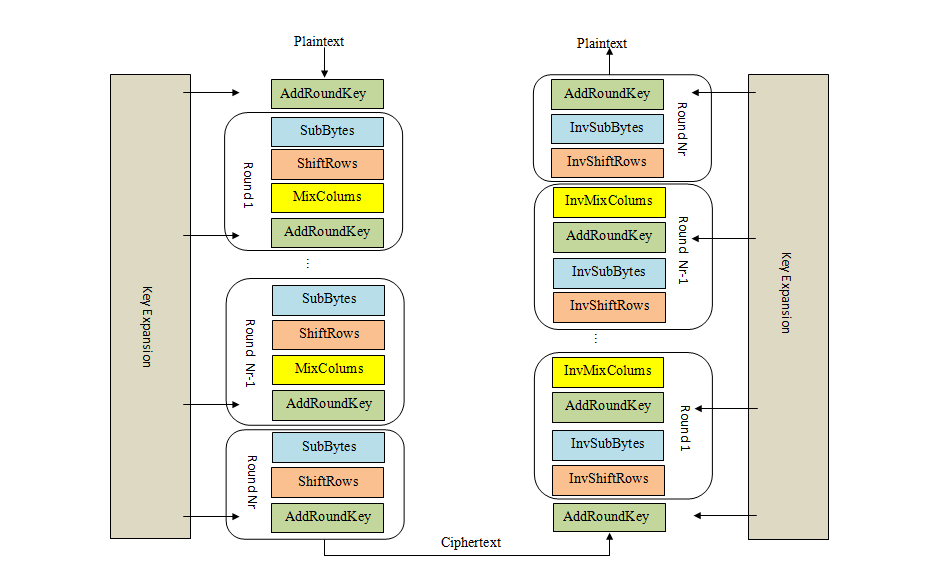

#### AddRoundKey

In [122]:
# dodawanie klucza rundy
def add_round_key(state, round_key):
    for i in range(4):
        for j in range(4):
            state[i][j] = XOR(state[i][j], round_key[i*4+j])

#### SubBytes
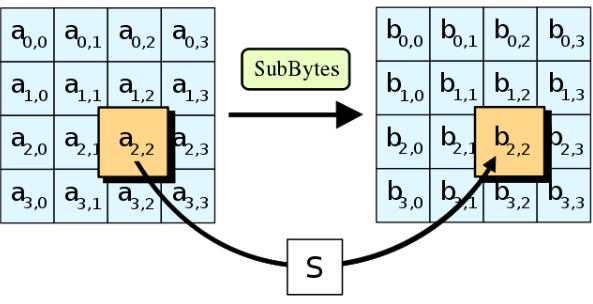

In [123]:
# aplikacja S-boxów
def sub_bytes(state):
    for i in range(4):
        for j in range(4):
            dec_state = int(state[i][j], 2)
            state[i][j] = decimal_to_binary(SBOX[dec_state])

# odwrócenie aplikacji S-boxów
def inv_sub_bytes(state):
    for i in range(4):
        for j in range(4):
            dec_state = int(state[i][j], 2)
            state[i][j] = decimal_to_binary(INV_SBOX[dec_state])

#### ShiftRows
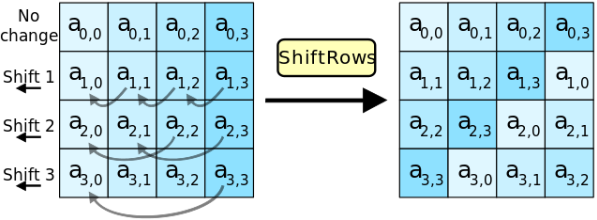

In [124]:
def shift_rows(s):
    s[0][1], s[1][1], s[2][1], s[3][1] = s[1][1], s[2][1], s[3][1], s[0][1]
    s[0][2], s[1][2], s[2][2], s[3][2] = s[2][2], s[3][2], s[0][2], s[1][2]
    s[0][3], s[1][3], s[2][3], s[3][3] = s[3][3], s[0][3], s[1][3], s[2][3]

def inv_shift_rows(s):
    s[0][1], s[1][1], s[2][1], s[3][1] = s[3][1], s[0][1], s[1][1], s[2][1]
    s[0][2], s[1][2], s[2][2], s[3][2] = s[2][2], s[3][2], s[0][2], s[1][2]
    s[0][3], s[1][3], s[2][3], s[3][3] = s[1][3], s[2][3], s[3][3], s[0][3]

#### MixColumns
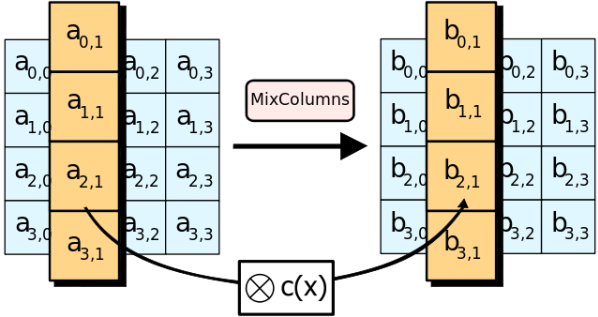

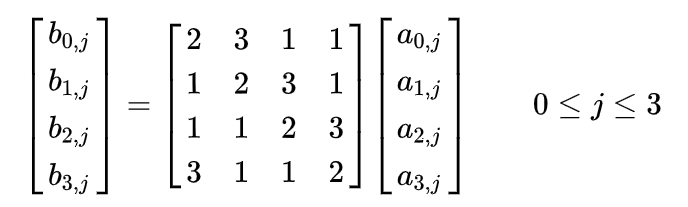

In [125]:
def mix_one_column(state):
    a = []
    for i in range(4):
        dec_state = int(state[i], 2)
        a.append(dec_state)
    
    state[0] = decimal_to_binary(gmul(a[0], 2) ^ gmul(a[3], 1) ^ gmul(a[2], 1) ^ gmul(a[1], 3))
    state[1] = decimal_to_binary(gmul(a[0], 1) ^ gmul(a[1], 2) ^ gmul(a[2], 3) ^ gmul(a[3], 1))
    state[2] = decimal_to_binary(gmul(a[1], 1) ^ gmul(a[0], 1) ^ gmul(a[2], 2) ^ gmul(a[3], 3))
    state[3] = decimal_to_binary(gmul(a[0], 3) ^ gmul(a[1], 1) ^ gmul(a[2], 1) ^ gmul(a[3], 2))

    
def mix_columns(state):
     for i in range(4):
        column = [state[0][i], state[1][i], state[2][i], state[3][i]]
        mix_one_column(column)
        state[0][i], state[1][i], state[2][i], state[3][i] = column


def inv_mix_one_column(state):
    a = [] 
    for i in range(4):
        dec_state = int(state[i], 2)
        a.append(dec_state)
    
    state[0] = decimal_to_binary(gmul(a[0], 14) ^ gmul(a[3], 9) ^ gmul(a[2], 13) ^ gmul(a[1], 11))
    state[1] = decimal_to_binary(gmul(a[1], 14) ^ gmul(a[0], 9) ^ gmul(a[3], 13) ^ gmul(a[2], 11))
    state[2] = decimal_to_binary(gmul(a[2], 14) ^ gmul(a[1], 9) ^ gmul(a[0], 13) ^ gmul(a[3], 11))
    state[3] = decimal_to_binary(gmul(a[3], 14) ^ gmul(a[2], 9) ^ gmul(a[1], 13) ^ gmul(a[0], 11))
    
    
        
def inv_mix_columns(state):
    for i in range(4):
        column = [state[0][i], state[1][i], state[2][i], state[3][i]]
        inv_mix_one_column(column)
        state[0][i], state[1][i], state[2][i], state[3][i] = column    

#example           
state = [
    ['11011011', '00010011', '01010011', '01000101'],
    ['01100100', '00000111', '00000001', '01100010'],
    ['00010010', '10000000', '10111111', '01111110'],
    ['11001110', '00101100', '00000101', '11010011']
]

mix_columns(state)
print(state)
inv_mix_columns(state)
print(state)

[['11011101', '10000011', '00011111', '10000001'], ['11101011', '10101010', '10001110', '11010000'], ['11010010', '01111011', '00111000', '10110101'], ['10000111', '11101010', '01000001', '01101110']]
[['11011011', '00010011', '01010011', '01000101'], ['01100100', '00000111', '00000001', '01100010'], ['00010010', '10000000', '10111111', '01111110'], ['11001110', '00101100', '00000101', '11010011']]


### Szyfrujmy AESem!

In [126]:
def bytes_to_matrix(text):
    """Converts a 16-byte array into a 4x4 matrix."""
    bytes_table = [text[i:i+8] for i in range(0, len(text), 8)]
    # return bytes_table
    return [bytes_table[i:i+4] for i in range(0, 16, 4)]


# szyfrowanie pojedynczego bloku 16 bajtowego
def aes128_encrypt(plain_text, key_128_bits):
    # wygenerujmy klucze rund
    key_schedule = expand_key(key_128_bits) # 11 podkluczy 
    # 4x4 grid 
    state = bytes_to_matrix(plain_text)

    # szyfrowanie
    add_round_key(state, key_schedule[:16])
    # 9 rund
    for i in range(1, 10):
        sub_bytes(state)
        shift_rows(state)
        mix_columns(state)
        add_round_key(state, key_schedule[16*i:16*(i+1)])
    # 10. runda
    sub_bytes(state)
    shift_rows(state)
    add_round_key(state, key_schedule[-16:])

    return state

# deszyfrowanie pojedynczego bloku 
def aes128_decrypt(cipher_text, key_128_bits):
    key_schedule = expand_key(key_128_bits)
    # 4x4 grid
    state = bytes_to_matrix(cipher_text)

    # deszyfrowanie klucze w odwrotnej kolejności, zmieniona kolejność operacji
    add_round_key(state, key_schedule[-16:])
    # 9 rund
    for i in range(9, 0, -1):
        inv_shift_rows(state)
        inv_sub_bytes(state)
        add_round_key(state, key_schedule[16*i:16*(i+1)])
        inv_mix_columns(state)
    # 10. runda
    inv_shift_rows(state)
    inv_sub_bytes(state)
    add_round_key(state, key_schedule[:16])

    return state

def AES_encrypt(plaintextData, keyData):
    cipher_text_list = aes128_encrypt(plaintextData, keyData)
    flat_list = [item for sublist in cipher_text_list for item in sublist]
    cipher_text = "".join(flat_list)
    return cipher_text

def AES_decrypt(cipher_text_data, keyData):
    plaintext_list = aes128_decrypt(cipher_text_data, keyData)
    flat_list = [item for sublist in plaintext_list for item in sublist]
    plaintext = "".join(flat_list)
    return plaintext
    
# blok 128-bitowy 
bin_plaintext = "00000000000000000000000000000000000000000001001000110100001100100100000000010101010001010001010101000011010100010011010001010001"
# klucz 128-bitowy 
bin_key =       "00000000000001111111100010001111111110001000111111111000100011111111100011111111000100011111111100010001111111110001000111111111"

print("Tekst jawny:")
print(bin_plaintext)

encrypted_message = AES_encrypt(bin_plaintext, bin_key)
print("Szyfrogram:")
print(encrypted_message)

decrypted_message = AES_decrypt(encrypted_message, bin_key)
print("Tekst odszyfrowany:")
print(decrypted_message)

Tekst jawny:
00000000000000000000000000000000000000000001001000110100001100100100000000010101010001010001010101000011010100010011010001010001
Szyfrogram:
00111100001001011111011000011101010010000111010111001100011001011100111010100001110000000001100011010011011001100111110000010001
Tekst odszyfrowany:
00000000000000000000000000000000000000000001001000110100001100100100000000010101010001010001010101000011010100010011010001010001


## Tryby algorytmów szyfrowych 
Stosowanie szyfrów blokowych wymaga rozwiązania dwóch problemów:
1. Co zrobić gdy wiadomość jest wieksza niż rozmiar bloku (przypomnienie: AES ma blok o rozmiarze 128 bitów)
2. Co zrobić gdy rozmiar wiadomości nie jest wielokrotnością rozmiaru bloków

Ad 1) Rozwiązaniem jest zastosowanie tzw. trybów algorytmów szyfrowych (*block cipher mode of operation*) czyli sposób szyfrowania wiadomości podzielonej na bloki.

Ad 2) Rozwiązaniem jest zastosowanie dopełnienia (*padding*) czyli porcji danych dodanych do ostatniego bloku w celu dopełnienia go do pełnej wielkości bloku


#### Zadanie 2:
Zapoznaj się z trybami ECB, CBC i CTR. Zaimplementuj je dla powyższej implementacji AES. 

In [127]:
# Funkcje pomocnicze 
from textwrap import wrap
import math 
from codecs import encode

# tablica znaków w tablicę kodów int
def intoIntArray(message):
    int_array = []
    msg_array = list(message) 
    for i in msg_array:
        int_array.append(ord(i))
    return int_array

def intListToBinStr(message_list):
    binary = []
    for x in message_list: 
        binary.append(get_bin(x, 8))
    binary_str = ""
    for x in binary:
        binary_str += x 
    return binary_str

def bin_str_to_byte_arr(byte_str):
    return [byte_str[i:i+8].zfill(8) for i in range(0, len(byte_str), 8)]

def byte_arr_to_str(byte_arr):
    return ''.join(chr(int(byte, 2)) for byte in byte_arr)

def byte_str_to_str(byte_str):
    return byte_arr_to_str(bin_str_to_byte_arr(byte_str))

def split_into_bin_chunks(plaintext):
    plaintext_list = intoIntArray(plaintext)
    plaintext_binary_str = intListToBinStr(plaintext_list)
    return wrap(plaintext_binary_str, 128)

# konwersja do postaci binarnej 
get_bin = lambda x, n: format(x, 'b').zfill(n)

# losowe dane dla wektora IV oraz Nonce
import random
random.seed("key")
random128bits = random.getrandbits(128)
print(random128bits)
iv = get_bin(random128bits,128)
print("IV: ", iv)

94955877992088634361269164448875663279
IV:  01000111011011111101011000111101111001101111111001101111101001111000111111000011101100100110000111011101101010011100111110101111


### Tryby ECB, CBC, CTR bez dopełnienia 

#### ECB (Electronic Code Book Mode)

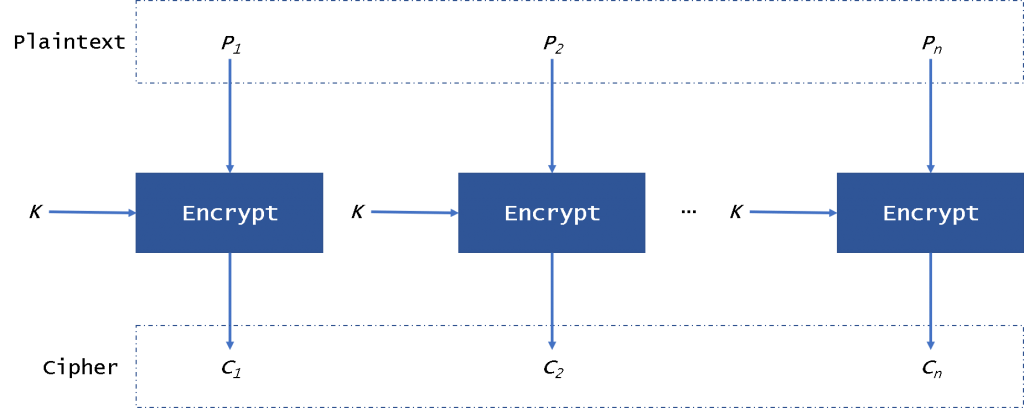
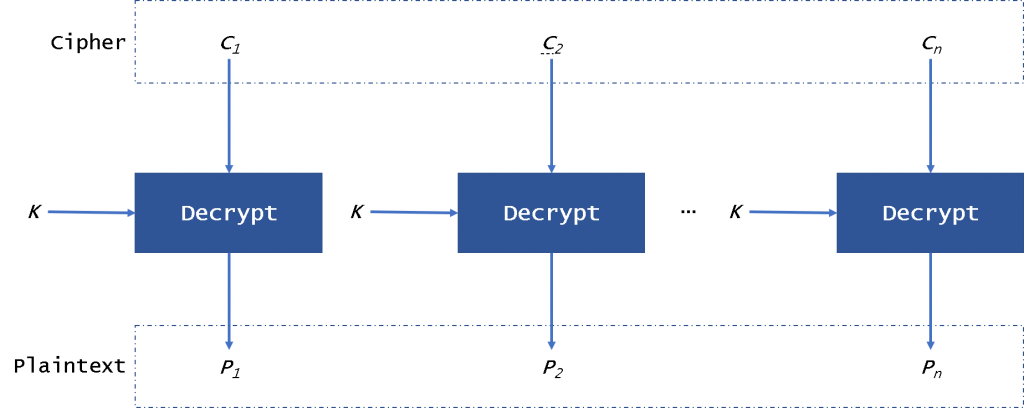

In [128]:
def ECB_encrypt(plaintext, bin_key):
    chunks = split_into_bin_chunks(plaintext)
    return byte_str_to_str(
        ''.join(AES_encrypt(chunk, bin_key) for chunk in chunks)
    )

def ECB_decrypt(cipher, bin_key):
    chunks = split_into_bin_chunks(cipher)
    return byte_str_to_str(
        ''.join(AES_decrypt(chunk, bin_key) for chunk in chunks)
    )

In [129]:
long_message = "Lorem ipsum dolor sit amet, consectetur adipiscing elit. In felis diam, maximus nec turpis duis."

bin_key = "00000000000001111111100010001111111110001000111111111000100011111111100011111111000100011111111100010001111111110001000111111111"

print("Szyfrowanie i deszyfrowanie w trybie ECB (Electronic Code Book Mode)")
encrypted_message = ECB_encrypt(long_message, bin_key)
print("Szyfrogram:")
print(encrypted_message)

decrypted_message = ECB_decrypt(encrypted_message, bin_key)
print("Tekst odszyfrowany:")
print(decrypted_message)

Szyfrowanie i deszyfrowanie w trybie ECB (Electronic Code Book Mode)
Szyfrogram:
®°Ñ@Êµo.ÎÒ8Ë:È¬IÖm££bï[»ápA6çfÌt°ÙÆÞÒL{;u F§AÙgeà
Tekst odszyfrowany:
Lorem ipsum dolor sit amet, consectetur adipiscing elit. In felis diam, maximus nec turpis duis.


#### CBC (Chaining Book Mode)

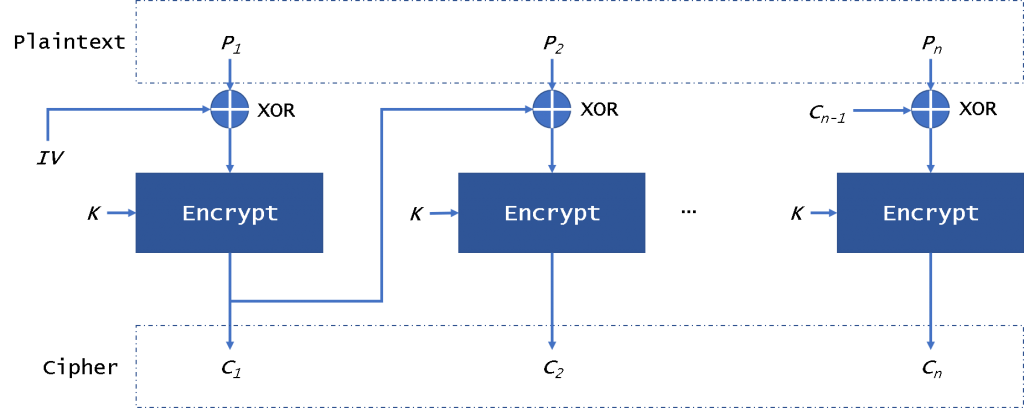
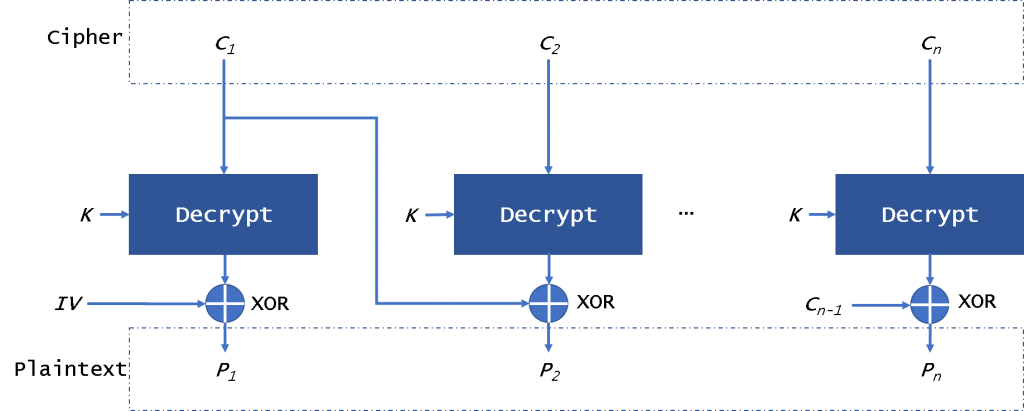

In [130]:
def CBC_encrypt(plaintext, bin_key, iv):
    plaintext_chunks = split_into_bin_chunks(plaintext)
    cipher_chunks = []

    prev_chunk = iv
    for chunk in plaintext_chunks:
        prev_chunk = AES_encrypt(XOR(prev_chunk, chunk), bin_key)
        cipher_chunks.append(prev_chunk)

    return byte_str_to_str(''.join(cipher_chunks))

def CBC_decrypt(cipher, bin_key, iv):
    cipher_chunks = split_into_bin_chunks(cipher)
    plaintext_chunks = []

    prev_chunk = iv
    for chunk in cipher_chunks:
        plaintext_chunks.append(XOR(AES_decrypt(chunk, bin_key), prev_chunk))
        prev_chunk = chunk

    return byte_str_to_str(''.join(plaintext_chunks))

In [131]:
long_message = "Lorem ipsum dolor sit amet, consectetur adipiscing elit. In felis diam, maximus nec turpis duis."

bin_key = "00000000000001111111100010001111111110001000111111111000100011111111100011111111000100011111111100010001111111110001000111111111"

random.seed("key")
random128bits = random.getrandbits(128)
iv = get_bin(random128bits, 128)

print("Szyfrowanie i deszyfrowanie w trybie CBC (Chaining Book Mode)")
encrypted_message = CBC_encrypt(long_message, bin_key, iv)
print("Szyfrogram:")
print(encrypted_message)

decrypted_message = CBC_decrypt(encrypted_message, bin_key, iv)
print("Tekst odszyfrowany:")
print(decrypted_message)

Szyfrowanie i deszyfrowanie w trybie CBC (Chaining Book Mode)
Szyfrogram:
¸l$úµ3ZD²ó¤ÝáK?
n ·§?lÄT»uði]!l¨Ä¸lÈ¢d½ô[F±z$)ìÌº÷/ýÙ ©á$m¸ÀP9¡Ü¹MÒÿÙ
Tekst odszyfrowany:
Lorem ipsum dolor sit amet, consectetur adipiscing elit. In felis diam, maximus nec turpis duis.


#### CTR (Counter Mode)

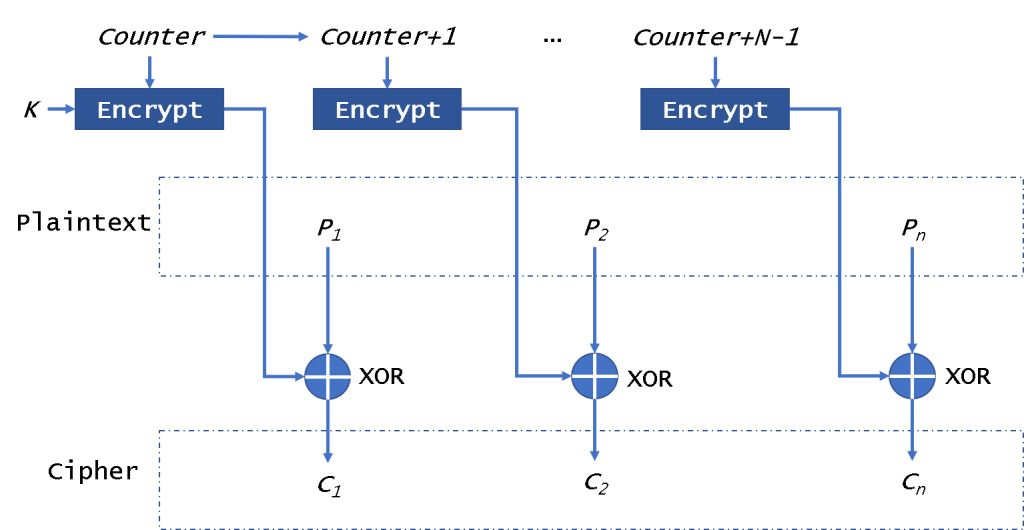
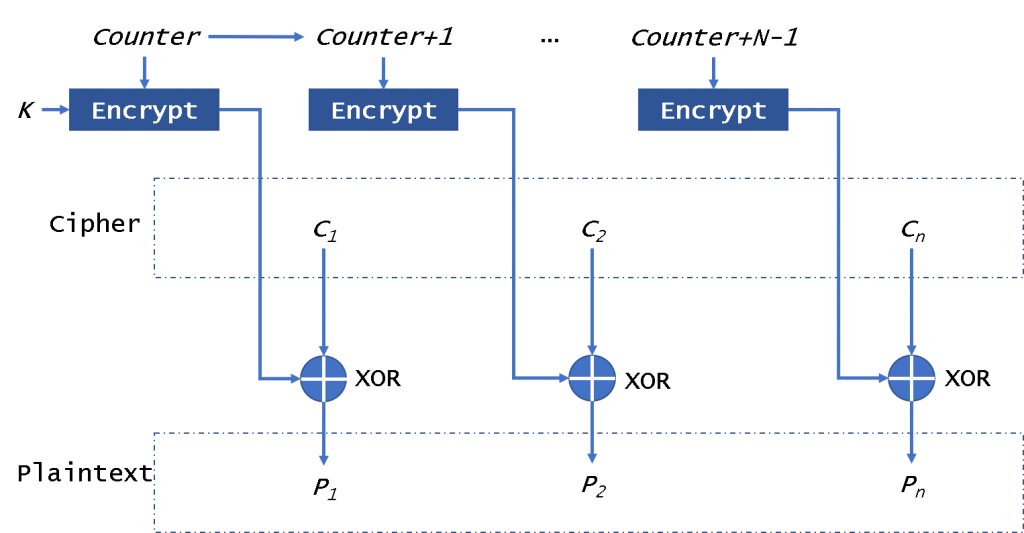

In [132]:
def increment_counter(count_vector):
    return bin(int(count_vector, 2) + 1)[2:]

def CTR_encrypt(plaintext, bin_key, count_vector):
    plaintext_chunks = split_into_bin_chunks(plaintext)
    cipher_chunks = []

    for chunk in plaintext_chunks:
        cipher_chunks.append(XOR(AES_encrypt(count_vector, bin_key), chunk))
        count_vector = increment_counter(count_vector)

    return byte_str_to_str(''.join(cipher_chunks))

def CTR_decrypt(cipher, bin_key, count_vector):
    cipher_chunks = split_into_bin_chunks(cipher)
    plaintext_chunks = []

    for chunk in cipher_chunks:
        plaintext_chunks.append(XOR(AES_encrypt(count_vector, bin_key), chunk))
        count_vector = increment_counter(count_vector)

    return byte_str_to_str(''.join(plaintext_chunks))

In [133]:
bin_key = "00000000000001111111100010001111111110001000111111111000100011111111100011111111000100011111111100010001111111110001000111111111"

random.seed("key")
random128bits = random.getrandbits(128)
count_vector = get_bin(random128bits, 128)

print("Szyfrowanie i deszyfrowanie w trybie CTR (Counter Mode)")
encrypted_message = CTR_encrypt(long_message, bin_key, count_vector)
print("Szyfrogram:")
print(encrypted_message)

decrypted_message = CTR_decrypt(encrypted_message, bin_key, count_vector)
print("Tekst odszyfrowany:")
print(decrypted_message)

Szyfrowanie i deszyfrowanie w trybie CTR (Counter Mode)
Szyfrogram:
KÑ¢2DÊ.-ÃB{ëìuÆ>Úuüh1_kïgü¯>fxtYaóÿ÷«&Ý&`YÜUs nåàêìbô+8}eÍeõB÷©eQ>f5o=û}éè
Tekst odszyfrowany:
Lorem ipsum dolor sit amet, consectetur adipiscing elit. In felis diam, maximus nec turpis duis.



#### Zadanie 3:
Zapoznaj się z dopełnieniem PKCS5 i zaimplementuj go (dla wybranego trybu algorytmu szyfrowego)

**Wybrałem tryb CBC**

In [134]:
BS = 16
pad = lambda s: s + (BS - len(s) % BS) * chr(BS - len(s) % BS)
unpad = lambda s : s[0:-ord(s[-1])]

def CBC_pad_encrypt(plaintext, bin_key, iv):
    return CBC_encrypt(pad(plaintext), bin_key, iv)

def CBC_pad_decrypt(cipher, bin_key, iv):
    return CBC_decrypt(unpad(cipher), bin_key, iv)

In [135]:
long_message_padding = "Lorem ipsum dolor sit amet, consectetur adipiscing elit. In felis diam, maximus nec turpis duis. Ut enim ad" 

bin_key = "00000000000001111111100010001111111110001000111111111000100011111111100011111111000100011111111100010001111111110001000111111111"

random.seed("key")
random128bits = random.getrandbits(128)
iv = get_bin(random128bits, 128)

print("Szyfrowanie i deszyfrowanie w trybie CBC (Chaining Book Mode)")
encrypted_message = CBC_encrypt(long_message, bin_key, iv)
print("Szyfrogram:")
print(encrypted_message)

decrypted_message = CBC_decrypt(encrypted_message, bin_key, iv)
print("Tekst odszyfrowany:")
print(decrypted_message)

Szyfrowanie i deszyfrowanie w trybie CBC (Chaining Book Mode)
Szyfrogram:
¸l$úµ3ZD²ó¤ÝáK?
n ·§?lÄT»uði]!l¨Ä¸lÈ¢d½ô[F±z$)ìÌº÷/ýÙ ©á$m¸ÀP9¡Ü¹MÒÿÙ
Tekst odszyfrowany:
Lorem ipsum dolor sit amet, consectetur adipiscing elit. In felis diam, maximus nec turpis duis.


### Literatura
- https://www.samiam.org/
- wikipedia Advanced Encryption Standard